In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
import copy
from collections import deque

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
class GameEnvironment:
    def __init__(self):
        self.hand = []
        self.score_potentials = []
        self.rolls_left = 3
        self.score_card = {
            'ones': -1, 'twos': -1, 'threes': -1,
            'fours': -1, 'fives': -1, 'sixes': -1,
            'three_of_a_kind': -1, 'four_of_a_kind': -1, 'full_house': -1,
            'small_straight': -1, 'large_straight': -1,
            'yahtzee': -1, 'chance': -1,
            'total_score': 0
        }
        self.label_score_dict = {
            0: 'ones', 1: 'twos', 2: 'threes', 3: 'fours', 4: 'fives', 5: 'sixes',
            6: 'three_of_a_kind', 7: 'four_of_a_kind', 8: 'full_house',
            9: 'small_straight', 10: 'large_straight', 11: 'yahtzee', 12: 'chance'
        }
    
    def get_state(self):
        return self.hand + [self.rolls_left] + list(self.score_card.values())
    
    def get_score_card(self):
        return self.score_card.copy()

    def roll_dice(self):
        num_dice_to_roll = 5 - len(self.hand)
        rolled_dice = [random.randint(1, 6) for _ in range(num_dice_to_roll)]
        self.hand = self.hand + rolled_dice
        self.rolls_left -= 1
        self.get_potential_scores()

    def update_hand(self, action_scalar, length=5):
        binary_string = f"{action_scalar:0{length}b}"
        decoded_action = torch.tensor([float(bit) for bit in binary_string])
        self.hand = [self.hand[x] for x in range(5) if decoded_action[x] == 1]
    
    def get_potential_scores(self):
        # Scoring logic
        potential_scores = {
            'ones': sum([x for x in self.hand if x == 1]),
            'twos': sum([x for x in self.hand if x == 2]),
            'threes': sum([x for x in self.hand if x == 3]),
            'fours': sum([x for x in self.hand if x == 4]),
            'fives': sum([x for x in self.hand if x == 5]),
            'sixes': sum([x for x in self.hand if x == 6]),
            'three_of_a_kind': sum(self.hand) if (
                np.unique(self.hand, return_counts = True)[1].max() >= 3
            ) else 0,
            'four_of_a_kind': sum(self.hand) if (
                np.unique(self.hand, return_counts = True)[1].max() >= 4
            ) else 0,
            'full_house': 25 if (
                (np.unique(self.hand, return_counts = True)[1].max() == 3) &
                (np.unique(self.hand, return_counts = True)[1].min() == 2)
            ) else 0,
            'small_straight': 30 if (
                all(number in self.hand for number in [1,2,3,4]) or
                all(number in self.hand for number in [2,3,4,5]) or
                all(number in self.hand for number in [3,4,5,6])
            ) else 0,
            'large_straight': 40 if (
                all(number in self.hand for number in [1,2,3,4,5]) or
                all(number in self.hand for number in [2,3,4,5,6])
            ) else 0,
            'yahtzee': 50 if len(set(self.hand)) == 1 else 0,
            'chance': sum(self.hand)
        }
        # If a score is already marked, remove it from potential scores
        for score_type in potential_scores.keys():
            if self.score_card[score_type] != -1:
                potential_scores[score_type] = 0
        self.score_potentials.append(potential_scores)

    def calc_reward_dice(self, pre_potentials, post_potentials):
        reward = sum(post_potentials.values()) - sum(pre_potentials.values())
        # offset = 1
        # base = 10
        # reward = np.sign(reward) * np.log(abs(reward) + offset) / np.log(base)
        return reward
    
    def calc_reward_score(self, pre_score_card, post_score_card, potential_scores, score_decision, score_amount):
        reward = score_amount
        # offset = 1
        # base = 10
        # reward = np.sign(reward) * np.log(abs(reward) + offset) / np.log(base)
        return reward
    
    def mark_score(self, chosen_score_type, chosen_score):
        self.score_card[chosen_score_type] = chosen_score
        self.score_card['total_score'] += chosen_score

    def reset_turn(self):
        self.hand = []
        self.score_potentials = []
        self.rolls_left = 3

    def reset_game(self):
        self.__init__()
        return self.get_state()

In [3]:
class DiceModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DiceModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.hidden_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))

        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        
        x = self.output_layer(x) # torch.sigmoid(self.fc3(x))
        return x
    
class ScoreModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(ScoreModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.hidden_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))

        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        
        x = self.output_layer(x)
        return x

In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, device):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, int(action), reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)

In [5]:
class DQNAgent:
    def __init__(
        self, state_size_dice, action_size_dice, state_size_score, action_size_score, hidden_sizes, 
        seed, device, buffer_size=10000, batch_size=64, gamma=0.99, lr=0.001, tau=1e-3, learn_every=4, learn_num=3
    ):
        self.seed = random.seed(seed)
        self.device = device

        # Initialize networks for keeping dice
        self.qnetwork_local_dice = DiceModel(state_size_dice, hidden_sizes, action_size_dice).to(self.device)
        self.qnetwork_target_dice = DiceModel(state_size_dice, hidden_sizes, action_size_dice).to(self.device)
        self.optimizer_dice = optim.Adam(self.qnetwork_local_dice.parameters(), lr=lr)

        # Initialize networks for keeping score
        self.qnetwork_local_score = ScoreModel(state_size_score, hidden_sizes, action_size_score).to(self.device)
        self.qnetwork_target_score = ScoreModel(state_size_score, hidden_sizes, action_size_score).to(self.device)
        self.optimizer_score = optim.Adam(self.qnetwork_local_score.parameters(), lr=lr)

        # Replay memory
        self.memory_dice = ReplayBuffer(buffer_size, batch_size, self.device)
        self.memory_score = ReplayBuffer(buffer_size, batch_size, self.device)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.learn_every = learn_every
        self.learn_num = learn_num

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done, network_type):
        # Save experience in replay memory
        if network_type == 'dice':
            memory = self.memory_dice
        elif network_type == 'score':
            memory = self.memory_score
        memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % self.learn_every
        if self.t_step == 0:
            if len(memory) > self.batch_size:
                for _ in range(self.learn_num):
                    experiences = memory.sample()
                    self.learn(experiences, self.gamma, network_type)

    def act_dice(self, state, eps=0.): # , thresold=0.5):
        # Exploration
        if random.random() < eps:
            action = torch.randint(0, 32, (1,)).item()
        # Exploitation
        else:
            state = torch.FloatTensor(state).to(self.device)
            self.qnetwork_local_dice.eval()
            with torch.no_grad():
                logits = self.qnetwork_local_dice(state)
                probs = torch.softmax(logits, dim=0)
                action = torch.argmax(probs).item()
            self.qnetwork_local_dice.train()
        return action

    def act_score(self, state, eps=0.):
        # Determine which score types are already taken
        invalid_actions = [x for x in range(13) if state[6:-1][x] != -1]
        # Exploration - random choice of valid actions
        if random.random() < eps:
            valid_actions = [x for x in range(13) if x not in invalid_actions]
            action = random.choice(valid_actions)
        # Exploitation - choose action with highest probability
        else:
            state = torch.FloatTensor(state).to(self.device)
            self.qnetwork_local_score.eval()
            with torch.no_grad():
                logits = self.qnetwork_local_score(state)
                probs = torch.softmax(logits, dim=0)
                # Remove invalid actions
                mask = torch.ones(13).to(self.device)
                mask[invalid_actions] = 0
                probs = probs * mask
                # Re-normalize
                probs = probs / probs.sum()  
                action = torch.argmax(probs).item()
            self.qnetwork_local_score.train()
        return action

    def learn(self, experiences, gamma, network_type):
        if network_type == 'dice':
            local_network = self.qnetwork_local_dice
            target_network = self.qnetwork_target_dice
            optimizer = self.optimizer_dice
            loss_func = nn.MSELoss() # nn.CrossEntropyLoss() # nn.BCELoss()
        elif network_type == 'score':
            local_network = self.qnetwork_local_score
            target_network = self.qnetwork_target_score
            optimizer = self.optimizer_score
            loss_func = nn.MSELoss() # nn.CrossEntropyLoss()
        # Unpack experiences into separate lists
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards.unsqueeze(1) + (gamma * Q_targets_next * (1 - dones.unsqueeze(1))) # rewards + (gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local model
        Q_expected = local_network(states).gather(1, actions.unsqueeze(1))
        # Compute loss
        loss = loss_func(Q_expected, Q_targets)
        # Backpropogate and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Soft-update target model
        self.soft_update(local_network, target_network, self.tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data) # or + tau?

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256 # 64
GAMMA = 0.99
LEARNING_RATE = 0.0005 # 0.001
TAU = 1e-3 # 1e-4
LEARN_EVERY = 4 
LEARN_NUM = 3

In [7]:
# Initialize environment
env = GameEnvironment()

# Set variables for agent
state_size_dice = 20
action_size_dice = 32
state_size_score = 20
action_size_score = 13
HIDDEN_SIZES = [256, 256, 256, 128, 128, 128, 64, 64]

# Initialize cuda and agent
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = DQNAgent(
    state_size_dice, action_size_dice, state_size_score, action_size_score, HIDDEN_SIZES, seed=0, device=device,
    buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, lr=LEARNING_RATE, tau=TAU, learn_every=LEARN_EVERY, learn_num=LEARN_NUM
)
init_local_params_dice = copy.deepcopy(agent.qnetwork_local_dice.state_dict())
init_local_params_score = copy.deepcopy(agent.qnetwork_local_score.state_dict())
init_target_params_dice = copy.deepcopy(agent.qnetwork_target_dice.state_dict())
init_target_params_score = copy.deepcopy(agent.qnetwork_target_score.state_dict())

'''Training loop variables'''
n_episodes = 10 # 10**4 * 5
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995 # 0.995

'''Start of training loop function'''
# Initialize variables
scores = []
scores_window = deque(maxlen=100)
eps = eps_start
start = time.time()

for i_episode in range(1, n_episodes+1):
    state = env.reset_game()
    score = 0
    done = False

    for turn in range(13):
        env.reset_turn()
        
        # First roll
        env.roll_dice()

        # First dice action - choose dice
        state = env.get_state()
        action_dice = agent.act_dice(state, eps)
        env.update_hand(action_dice)

        # Second roll
        env.roll_dice()

        # Calculate reward and step
        next_state = env.get_state()
        reward_dice = env.calc_reward_dice(env.score_potentials[0], env.score_potentials[1])
        agent.step(state, action_dice, reward_dice, next_state, done, 'dice')
        state = next_state

        # Second dice action - choose dice
        action_dice = agent.act_dice(state, eps)
        env.update_hand(action_dice)

        # Final roll
        env.roll_dice()
        done = True if turn == 12 else False

        # Calculate reward and step
        next_state = env.get_state()
        reward_dice = env.calc_reward_dice(env.score_potentials[1], env.score_potentials[2])
        agent.step(state, action_dice, reward_dice, next_state, done, 'dice')
        state = next_state

        # Score action - choose score
        pre_score_card = env.get_score_card()
        action_score = agent.act_score(state, eps)

        # Mark score
        score_decision = env.label_score_dict[action_score]
        score_amount = env.score_potentials[2][score_decision]
        env.mark_score(score_decision, score_amount)
        post_score_card = env.get_score_card()

        # Calculate reward and step
        next_state = env.get_state()
        reward_score = env.calc_reward_score(pre_score_card, post_score_card, env.score_potentials[2], score_decision, score_amount)
        agent.step(state, action_score, reward_score, next_state, done, 'score')

    score = env.score_card['total_score']
    scores_window.append(score)
    scores.append(score)

    if i_episode % ((n_episodes/100) + 1) == 0:
        eps = max(eps_end, eps_decay * eps)

    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpsilon: {eps:.2f}\tTime - {(time.time() - start) / 60:.2f} min', end="")
    
    if i_episode % (n_episodes/10) == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpsilon: {eps:.2f}\tTime - {(time.time() - start) / 60:.2f} min')
    
    if np.mean(scores_window) >= 100.0:
        print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
        torch.save(agent.qnetwork_local_dice.state_dict(), 'checkpoint_keep.pth')
        torch.save(agent.qnetwork_local_score.state_dict(), 'checkpoint_score.pth')

Episode 5000	Average Score: 49.39	Epsilon: 0.96	Time - 12.97 min
Episode 10000	Average Score: 46.07	Epsilon: 0.91	Time - 26.03 min
Episode 15000	Average Score: 49.37	Epsilon: 0.86	Time - 39.33 min
Episode 20000	Average Score: 46.44	Epsilon: 0.82	Time - 51.13 min
Episode 25000	Average Score: 45.75	Epsilon: 0.78	Time - 61.65 min
Episode 30000	Average Score: 45.76	Epsilon: 0.74	Time - 71.79 min
Episode 35000	Average Score: 45.08	Epsilon: 0.71	Time - 83.32 min
Episode 40000	Average Score: 44.87	Epsilon: 0.67	Time - 95.17 min
Episode 45000	Average Score: 46.14	Epsilon: 0.64	Time - 106.45 min
Episode 50000	Average Score: 46.73	Epsilon: 0.61	Time - 118.66 min


In [28]:
env.get_potential_scores()

In [21]:
env.score_card.items()

dict_items([('ones', 2), ('twos', 2), ('threes', 3), ('fours', 4), ('fives', 0), ('sixes', 0), ('three_of_a_kind', 0), ('four_of_a_kind', 0), ('full_house', 0), ('small_straight', 0), ('large_straight', 0), ('yahtzee', 0), ('chance', 22), ('total_score', 33)])

In [8]:
experiences, gamma, network_type = agent.memory_score.sample(), GAMMA, 'score'    

if network_type == 'dice':
    local_network = agent.qnetwork_local_dice
    target_network = agent.qnetwork_target_dice
    optimizer = agent.optimizer_dice
    loss_func = nn.MSELoss() # nn.CrossEntropyLoss()
elif network_type == 'score':
    local_network = agent.qnetwork_local_score
    target_network = agent.qnetwork_target_score
    optimizer = agent.optimizer_score
    loss_func = nn.MSELoss() # nn.CrossEntropyLoss()
# Unpack experiences into separate lists
states, actions, rewards, next_states, dones = experiences
# Get max predicted Q values (for next states) from target model
Q_targets_next = target_network(next_states).detach().max(1)[0].unsqueeze(1)
Q_targets = rewards.unsqueeze(1) + (gamma * Q_targets_next * (1 - dones.unsqueeze(1))) # rewards + (gamma * Q_targets_next * (1 - dones))
# Get expected Q values from local model
Q_expected = local_network(states).gather(1, actions.unsqueeze(1))
# Compute loss
loss = loss_func(Q_expected, Q_targets)

In [9]:
current_local_params_dice = copy.deepcopy(agent.qnetwork_local_dice.state_dict())
current_local_params_score = copy.deepcopy(agent.qnetwork_local_score.state_dict())
current_target_params_dice = copy.deepcopy(agent.qnetwork_target_dice.state_dict())
current_target_params_score = copy.deepcopy(agent.qnetwork_target_score.state_dict())

In [10]:
import itertools

for q_type, action_type in itertools.product(['local', 'target'], ['dice', 'score']):

    if q_type == 'local':
        if action_type == 'dice':
            initial = init_local_params_dice
            current = current_local_params_dice
        elif action_type == 'score':
            initial = init_local_params_score
            current = current_local_params_score
    elif q_type == 'target':
        if action_type == 'dice':
            initial = init_target_params_dice
            current = current_target_params_dice
        elif action_type == 'score':
            initial = init_target_params_score
            current = current_target_params_score

    print(f'\n{q_type} -- {action_type} --')
    param_differences = {}
    for param_name in initial:
        initial_param = initial[param_name]
        current_param = current[param_name]
        param_differences[param_name] = (current_param - initial_param).abs().mean().item()

    # Print the parameter differences
    for param_name, difference in param_differences.items():
        print(f"Parameter: {param_name}, Mean Absolute Difference: {difference}")


local -- dice --
Parameter: input_layer.weight, Mean Absolute Difference: 0.12982723116874695
Parameter: input_layer.bias, Mean Absolute Difference: 0.13248443603515625
Parameter: hidden_layers.0.weight, Mean Absolute Difference: 0.115223728120327
Parameter: hidden_layers.0.bias, Mean Absolute Difference: 0.10505426675081253
Parameter: hidden_layers.1.weight, Mean Absolute Difference: 0.11448322236537933
Parameter: hidden_layers.1.bias, Mean Absolute Difference: 0.10686194896697998
Parameter: hidden_layers.2.weight, Mean Absolute Difference: 0.13297316431999207
Parameter: hidden_layers.2.bias, Mean Absolute Difference: 0.15499120950698853
Parameter: hidden_layers.3.weight, Mean Absolute Difference: 0.14737039804458618
Parameter: hidden_layers.3.bias, Mean Absolute Difference: 0.2247287631034851
Parameter: hidden_layers.4.weight, Mean Absolute Difference: 0.1584581732749939
Parameter: hidden_layers.4.bias, Mean Absolute Difference: 0.24859778583049774
Parameter: hidden_layers.5.weight,

In [11]:
for target, expected in zip(Q_targets, Q_expected):
    print(f'Target: {target.item():4f}, Expected: {expected.item():4f}')

Target: 0.000000, Expected: 4.563137
Target: 0.000000, Expected: 8.807869
Target: 0.000000, Expected: 3.096425
Target: 20.993841, Expected: 23.677082
Target: 23.037207, Expected: 44.352177
Target: 7323.008301, Expected: 7321.584473
Target: 15.485868, Expected: 16.178547
Target: 9.894644, Expected: 13.301423
Target: 31.957365, Expected: 35.760323
Target: 27.260185, Expected: 23.167732
Target: 257.889679, Expected: 218.414352
Target: 45.344055, Expected: 40.298233
Target: 12.252589, Expected: 11.616371
Target: 9.752342, Expected: 13.401367
Target: 13.275702, Expected: 18.384567
Target: 7.278747, Expected: 6.752117
Target: 12.592152, Expected: 12.746131
Target: 13.381138, Expected: 11.649648
Target: 21.992617, Expected: 43.284378
Target: 21.509319, Expected: 24.095362
Target: 344.221466, Expected: 261.928223
Target: 0.477121, Expected: -4.799522
Target: 16.844887, Expected: 20.853764
Target: 17.271811, Expected: 20.563585
Target: 127.087173, Expected: 68.068359
Target: 21.145144, Expected

In [12]:
errors = Q_expected - Q_targets
errors_squared = errors**2
errors_squared.mean()

tensor(1064.2625, device='cuda:0', grad_fn=<MeanBackward0>)

In [13]:
loss

tensor(1064.2625, device='cuda:0', grad_fn=<MseLossBackward0>)

In [14]:
local_model = agent.qnetwork_local_dice
target_model = agent.qnetwork_target_dice
tau = TAU

for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
    target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data) # or + tau?

In [15]:
results = pd.DataFrame()

for experience in agent.memory_dice.memory:
    state, action, reward, next_state, done = experience
    result = pd.DataFrame({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})
    results = pd.concat([results, result], ignore_index=True)

In [16]:
np.unique(results.action, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 4380,  5860,  4580,  3740,  5160,  3720,  4740,  3720,  3960,
        12640,  4340,  3420, 10680, 11260,  4000,  8160,  3340,  4580,
         3480,  4660,  3520,  4180,  6940,  3740,  4540,  3660,  5700,
         3920, 22180,  9160,  4920, 17120]))

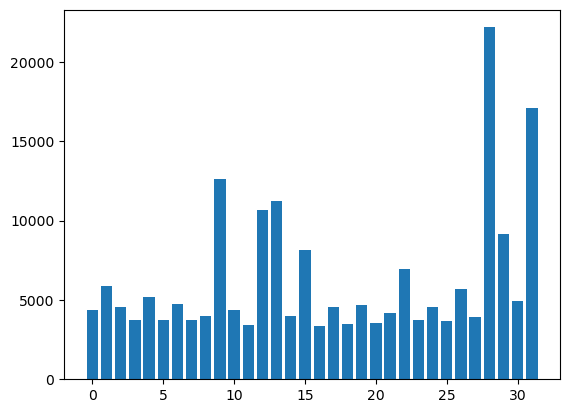

In [17]:
plt.figure()
plt.bar(np.unique(results.action, return_counts=True)[0], np.unique(results.action, return_counts=True)[1])
plt.show()

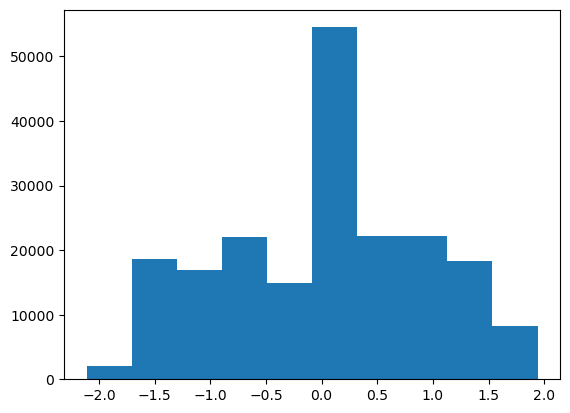

In [18]:
plt.figure()
plt.hist(results.reward)
plt.show()